<a href="https://colab.research.google.com/github/pgurazada/understanding-embeddings/blob/main/understanding_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Introduce the role of embeddings in LLM applications
- Understand Byte-Pair Encoding (BPE) tokenization used by LLMs
- Understand the computation of Sentence Embeddings using encoder-only models
- Explore the application of embeddings in legal contexts, specifically:
  - Finding Similar Legal Cases: Learn how to leverage embeddings for identifying relevant legal precedents based on case summaries, enhancing research efficiency and case preparation.
  - Document Similarity and Clustering: Understand how to organize and manage large volumes of legal documents through clustering techniques, improving document retrieval and knowledge management in legal practice.
- Gain practical experience in implementing embedding techniques using popular libraries such as Sentence Transformers and visualizing results using tools like t-SNE and K-Means clustering.

# Setup

In [ ]:
!pip install -q tiktoken==0.5.2 \
                sentence-transformers==2.3.1 2>/dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
import tiktoken
from sentence_transformers import SentenceTransformer, util

# Introduction

Before text is passed on to an LLM for a prediction, two crucial steps are involved:
- Tokenization, that is splitting of input text into constituent tokens
- Embedding, that is mapping each token to a $n-$dimensional vector


In the realm of Large Language Models (LLMs), a *token* refers to a unit of text representing a word, phrase, or any other textual element. Tokens can range from complete words to partial symbols (for e.g., :), ', ., !), serving as fundamental components for LLMs to grasp text semantics. This notebook delves into Byte-Pair Encoding, a widely-used technique for tokenizing input text.

When crafting an *embedding* for a token, our aim is to generate a numerical representation linked to the token that encapsulates its meaning and context. Typically, these representations manifest as high-dimensional vectors (for e.g., 1024, 768), with each feature encoding a learned language attribute.

Beyond serving as the foundational layer of LLMs, embeddings serve as essential elements for executing various natural language tasks, such as summarization, translation, and classification. They play a pivotal role in Retrieval-Augmented Generation (RAG), where an input query retrieves relevant documents from a vector database, and the query is addressed using these documents as context.

# Byte-Pair Encoding for Tokenization

## Exploring LLM tokens

Let us begin with a closer look at tokenization, that is, splitting input text into constituent tokens. Before we get to the actual algorithm that executes tokenization for modern LLMs, let us see this tokenizer in action.

Open AI has packaged its tokenizers into the open source package `tiktoken` that we will use to explore the tokenizer for GPT4.

In [ ]:
tokenizer_gpt4 = tiktoken.encoding_for_model("gpt-4")

In [ ]:
tokenizer_gpt4.n_vocab

100277

Notice how the vocabulary of GPT 4 is 100,277. This means that individual words in the input text are mapped to one of these 100,277 token ids. Let us see this in action.

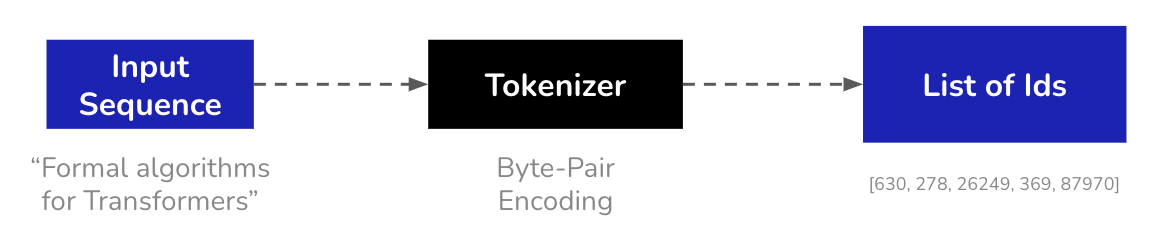

In [ ]:
tokenizer_gpt4.encode("formal algorithms for transformers")

[630, 278, 26249, 369, 87970]

The above output indicates that the 4 words in the input text are mapped to 5 tokens with each token identified by a unique id. How did 4 words translate to 5 tokens?

To observe how sentences are mapped to tokens, let us look at how the above reference sentence is split using a function defined below.

In [ ]:
def print_tokens_from_input(sentence: str, tokenizer):
    """
    Loop over each token of an encoded sentence.
    Use the .decode method of the tokenizer to print
    the token that is encoded in the first step.
    """
    for token_id in tokenizer.encode(sentence):
        print(tokenizer.decode([token_id]))

In [ ]:
text = "formal algorithms for transformers"
print_tokens_from_input(text, tokenizer_gpt4)

form
al
 algorithms
 for
 transformers


Notice from the output how the word - `formal` - is split into `form` and `al`. This is how the 4 words get mapped into 5 tokens. Let us look at a longer sentence.

In [ ]:
text = "Tokenizers map individual tokens to a vocabulary using a set of rules specified by byte-pair encoding"
print_tokens_from_input(text, tokenizer_gpt4)

Token
izers
 map
 individual
 tokens
 to
 a
 vocabulary
 using
 a
 set
 of
 rules
 specified
 by
 byte
-p
air
 encoding


As the above output indicates, sub-words are often used to form tokens. Under the hood, modern LLMs use an algorithm called Byte-Pair Encoding to create these tokens and optimize the vocabulary of LLMs. Let's dive into this algorithm.

## Byte-Pair Encoding

Consider the sentence - `formal algorithms for transformers`. As a part of tokenization, we want to split this sentence into its constituent meaningful units of information.

As an algorithm to do so, if we consider 26 alphabets as the atomic units of our vocabulary, we can represent any sentence using this vocabulary. For example, we can represent this sentence as a list of ids corresponding to the alphabets used in the sentence using the following process:

In [ ]:
sentence = 'formal algorithms for transformers'

To create tokens for this sentence, we can create a lookup index for the individual alphabets as a dictionary.

In [ ]:
alphabets = 'abcdefghijklmnopqrstuvwxyz'
alphabet_ids = {alphabet: index for index, alphabet in enumerate(alphabets)}

In [ ]:
alphabet_ids

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

We add an extra character for a white space.

In [ ]:
alphabet_ids[' '] = 26

We can now loop through each character in the sentence and look up its index from the dictionary created above like so:

In [ ]:
[alphabet_ids[char] for char in list(sentence)]

[5,
 14,
 17,
 12,
 0,
 11,
 26,
 0,
 11,
 6,
 14,
 17,
 8,
 19,
 7,
 12,
 18,
 26,
 5,
 14,
 17,
 26,
 19,
 17,
 0,
 13,
 18,
 5,
 14,
 17,
 12,
 4,
 17,
 18]

While this character-level encoding achieves the purpose of translating a sentence of input text to a list of unique ids, it uses up a lot of indices (i.e., we create long lists). On the other hand if we use full words as a part of our vocabulary, it creates a large vocabulary and small lists of ids. This is also wasteful since minor variations in words (e.g., algorithm, algorithms) will add an additional word to the vocabulary.

Byte-Pair Encoding optimizes the tokenization process by creating a vocabulary of desired length by representing common words as a single token. Rare words are split into two or more subword tokens. This balances the vocabulary size and the length of the list of ids created during tokenization.

To illustrate this algorithm, consider the following corpus of two sentences.

In [ ]:
sentences_in_corpus = [
    'formal algorithms for transformers',
    'normal algorithms for transformers'
]

The word frequencies in this corpus are:

In [ ]:
word_frequencies_in_corpus = {
    'algorithms': 2,
    'for': 2,
    'transformers': 2,
    'formal': 1,
    'normal': 1
}

Our character-level vocabulary for this corpus is:

In [ ]:
set(character for word in word_frequencies_in_corpus.keys() for character in word)

{'a', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't'}

In byte-pair encoding, we use these individual words to start pairing individual characters in the word frequencies. For example, the pair (`f`, `o`) is present in the words `formal`, `for` and `transformers`. This is the most frequent pair of characters in the corpus since it occurs $1 + 2 + 2 = 5$ times in the corpus. Notice how we have used the word frequencies to arrive at this number.

Since this is the most frequent pair, we create a rule `(f, o) -> fo` and store the word `fo` as a word in our vocabulary. That is, we assign `fo` a dedicated index. At this point our vocabulary looks like so:

In [ ]:
word_frequencies_in_corpus = {
    'algorithms': 2,
    'fo r': 2,
    'trans fo rmers': 2,
    'fo rmal': 1,
    'normal': 1
}

In [ ]:
set(subword for word in word_frequencies_in_corpus.keys() for subword in word.split(' '))

{'algorithms', 'fo', 'normal', 'r', 'rmal', 'rmers', 'trans'}

Notice how the subword `fo` is a part of the vocabulary now.

We now start pairing again. In this case, the pair `(fo, r)` occurs $2 + 2 + 1 = 5$ times. Again this is the most frequent pair so we add the rule `(fo, r) -> for` to our vocabulary. The vocabulary now looks like so:

In [ ]:
word_frequencies_in_corpus = {
    'algorithms': 2,
    'for': 2,
    'trans for mers': 2,
    'for mal': 1,
    'normal': 1
}

In [ ]:
set(subword for word in word_frequencies_in_corpus.keys() for subword in word.split(' '))

{'algorithms', 'for', 'mal', 'mers', 'normal', 'trans'}

We repeat this process till we reach the vocabulary size that is desired (e.g., 100,277 for GPT-4). Once the vocabulary size is reached we assign an integer index to each token in the vocabulary (just like we did before for a character-level encoding). As a part of this process, subwords appear naturally and allow us to optimize the vocabulary size while retaining the expressiveness of language.

To recap, at the end of tokenization using byte-pair encoding we obtain a mapping from an input text to a list of token ids.

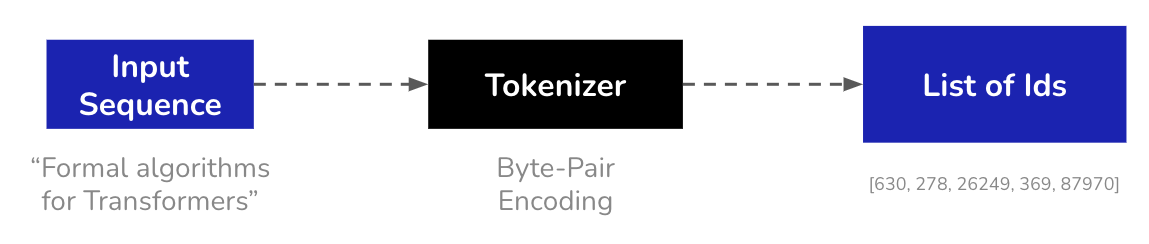

# Sentence Embeddings

## What do embeddings accomplish?

Now that we have a list of token ids, the next step is to imbibe meaning and context to these tokens. This is usually executed using encoder-only models such as BERT. The overall process of embedding is summarized in the following figure.

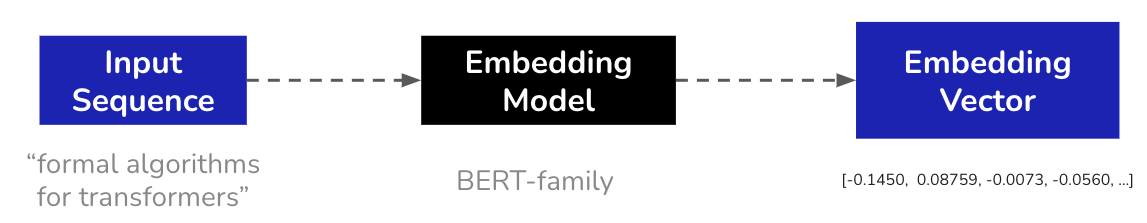

Let us see embeddings in action. We will use the MiniLM-L6-model from HuggingFace that was trained to retrieve pairs of sentences that are similar to each other. This model provides a good balance of size and embedding accuracy.

In [ ]:
embedding_model_name = "all-MiniLM-L6-v2"

In [ ]:
embedding_model = SentenceTransformer(embedding_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedding_model.max_seq_length

256

The above output indicates that the model accepts sentences/paragraphs with a maximum length of 256 tokens. Any text more than this length is truncated to include only the first 256 tokens.

Let us now present an example sentence to the embedding model and collect its vector representation.

In [ ]:
sentence = "formal algorithms for transformers"

In [ ]:
embeddings = embedding_model.encode(sentence)

In [ ]:
embeddings.shape

(384,)

The above output indicates that the input sentence is now represented as a vector of dimension 384. We can inspect the values of the embedding vector like so:

In [ ]:
embeddings[0:4]

array([-0.14508992,  0.0875918 , -0.00733512, -0.0560404 ], dtype=float32)

Such general embedding models that can generate embeddings for any text unlock several applications (e.g., Retrieval-Augmented Generation) since we can measure the closeness of any two pairs of sentences in the high-dimensional space represented by the embedding.

Let us look at a specific example. Imagine we have a text database of financial information about Tesla. Given any user query, we want to retrieve the relevant context sentence that is closely related to the user query.  

In [ ]:
context_sentence1 = "The annual revenue for Tesla in 2022 was $ 81.46 billion"
context_sentence2 = "The annual revenue for Tesla in 2021 was $ 53.82 billion"

user_query = "What was the annual revenue for Tesla in 2022?"

Let us combine these context sentences and create embeddings for them.

In [ ]:
context_sentences = [context_sentence1, context_sentence2]

In [ ]:
context_embeddings = embedding_model.encode(context_sentences)

In [ ]:
context_embeddings.shape

(2, 384)

In [ ]:
user_query_embedding = embedding_model.encode(user_query)

We can now measure the cosine similarity of the user quert to each of the context sentences to determine which of the context sentences is similar to the query.

In [ ]:
for embedding, sentence in zip(context_embeddings, context_sentences):
    similarity = util.pytorch_cos_sim(user_query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.8941]]) The annual revenue for Tesla in 2022 was $ 81.46 billion
tensor([[0.8476]]) The annual revenue for Tesla in 2021 was $ 53.82 billion


As we can see from the output above, the user query is measured to be closer to context sentence 1 than context sentence 2 (as is expected).

Now that we have seen the practical utility of generating embeddings, let us dig deeper into how these embeddings are computed.

The steps involved in creating embeddings for an input sentence are presented in the figure below.

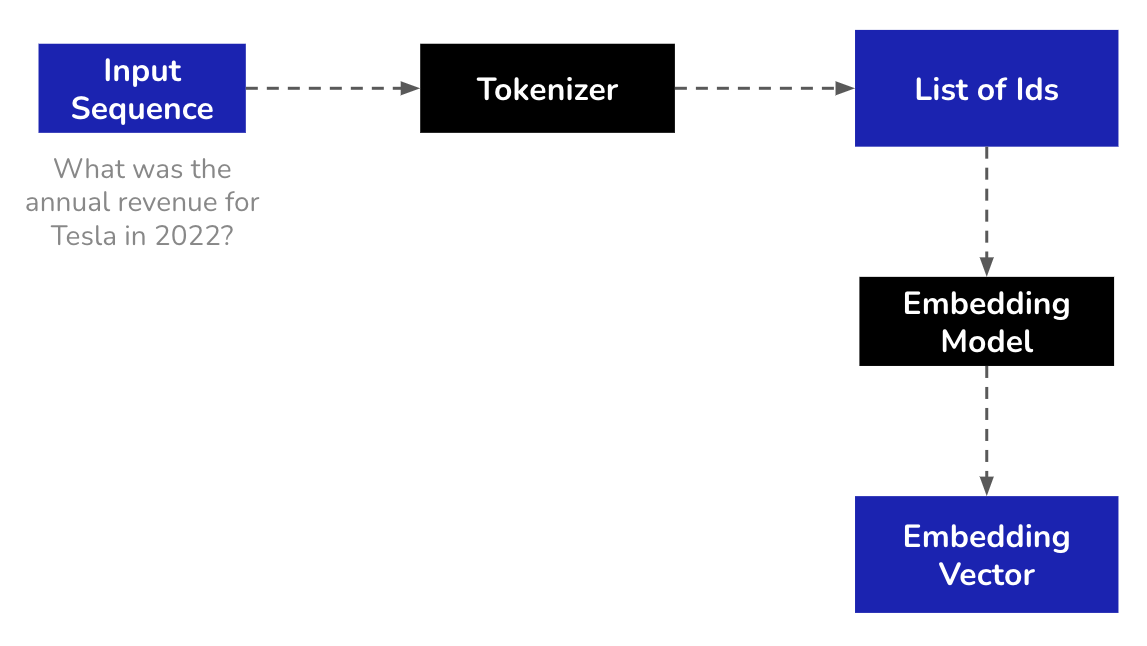

We illustrate this two step process of generating embeddings for an input sentence using the following example sentence.

In [ ]:
context_sentence = "The annual revenue for Tesla in 2022 was $ 81.46 billion"

## Step 1: Tokenize

The first step in generating embeddings for the above sentence is to extract tokens from the input text. This process is no different from what we have seen with byte-pair encoding where pairs of characters are fused using word frequencies.

Let us look at the tokenizer used by our Mini-LM-L6 model.

In [ ]:
embedding_model.tokenizer

BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

We can see that this model has a vocabulary of 30,522 tokens, with a few special tokens sprinkled in. Specifically:
- `[UNK]` used to represent tokens that were not seen during training
-  `[PAD]` used to pad sentences smaller than the context length (512) on the right
- `[MASK]` used to mask a random token in the input that will be predicted during training (more on this shortly)
- `[CLS]` appended at the beginning of every sentence to represent its overall meaning
- `[SEP]` used to separate sentences

Let us now see how this tokenizer splits the user query presented above.

In [ ]:
embedding_model.tokenizer(context_sentence)

{'input_ids': [101, 1996, 3296, 6599, 2005, 26060, 1999, 16798, 2475, 2001, 1002, 6282, 1012, 4805, 4551, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
embedding_model.tokenizer(context_sentence).tokens()

['[CLS]',
 'the',
 'annual',
 'revenue',
 'for',
 'tesla',
 'in',
 '202',
 '##2',
 'was',
 '$',
 '81',
 '.',
 '46',
 'billion',
 '[SEP]']

In [ ]:
len(embedding_model.tokenizer(context_sentence).tokens())

16

As the above output indicates, the input sequence of 11 words is split into 16 tokens including 2 special tokens.

## Step 2: Pool token embeddings

In order to generate an overall embedding for an input sentence, we first generate a high-dimensional representation for each token in the sentence using a masked language modeling objective. We use an encoder-only transformer model (usually) belonging to the BERT family for this objective. The training procedure is depicted in the figures below.

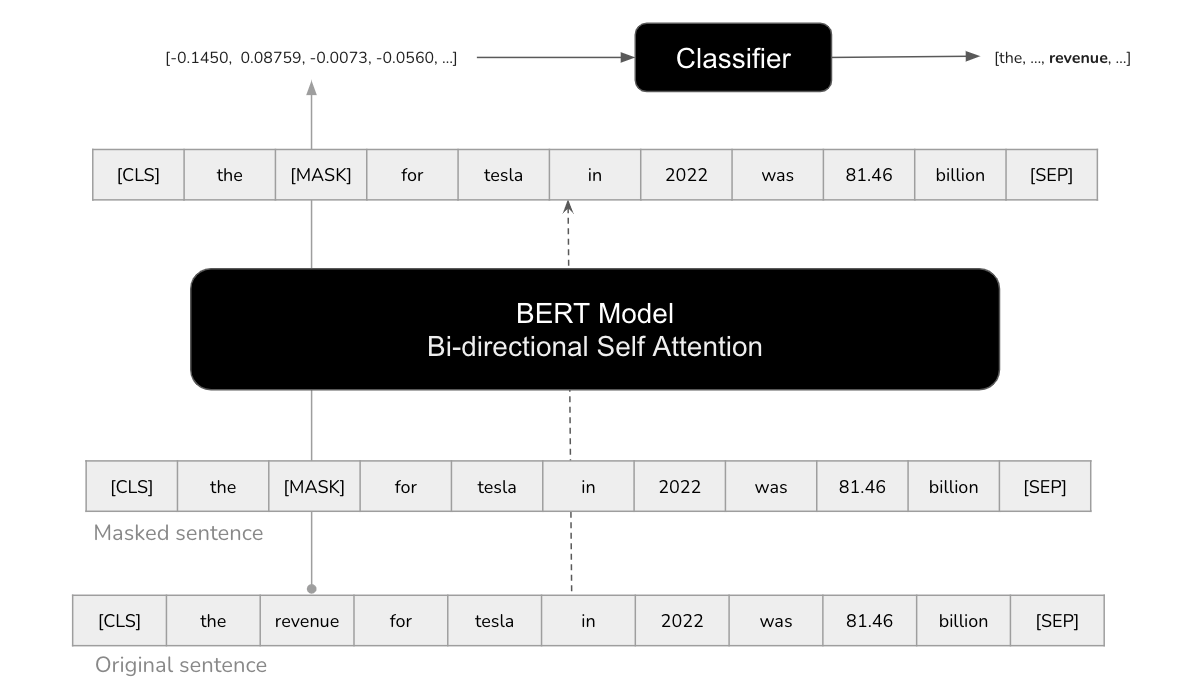

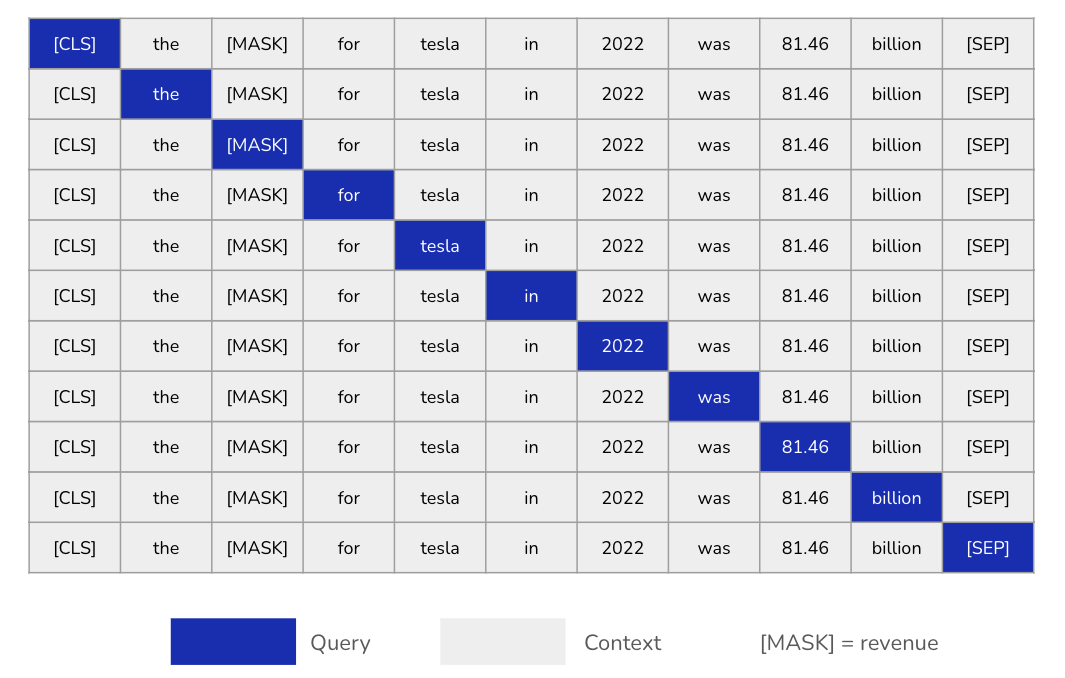

In the training procedure presented above, the `[MASK]` token forces the model to contextualize the other words in the sentence with original word access disabled. This was the clever invention from the BERT-paper in 2018 that contrasted with the decoder-only approach of Open AI GPT.

The final output from the transformer model is a $n-$dimensional vector associated with each token in the input sentence. However, we need one vector associated with the entire sentence. How would we achieve this?

Let us look at the embedding model to see how this is done.

In [ ]:
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

As the above output indicates, the embedding model pools all the $n-$dimensional vectors of the tokens in the sentence by averaging them to get one $n-$dimensional vector.

Let us dig into this pooling process further.

In [ ]:
context_sentence = "The annual revenue for Tesla in 2022 was $ 81.46 billion"

In [ ]:
input_sentence_embedding = embedding_model.encode(context_sentence)

In [ ]:
input_sentence_embedding.shape

(384,)

As the output indicates, we get one $384-$dimensional vector as a representation of the input text. However, the individual token vectors are also available for inspection like so:

In [ ]:
input_token_embedding = embedding_model.encode(context_sentence, output_value="token_embeddings")

In [ ]:
input_token_embedding.shape

torch.Size([16, 384])

From the output above we can see that each of the tokens is conferred a $384-$dimensional representation. These representations are then averaged to obtain a single vector representation for the sentence.

# Exploring power of Embeddings using Legal domain

## Business Context

In the legal profession, the ability to efficiently locate and analyze relevant case law is crucial for effective representation and decision-making. With the exponential growth of legal cases and documents, traditional search methods often fall short, leading to wasted time and resources. This necessitates a more intelligent approach to legal research that leverages technology to enhance efficiency and accuracy.

The first section of the notebook focuses on using embeddings to find similar legal cases based on their summaries. This capability is instrumental for legal practitioners who need quick access to relevant precedents to strengthen their arguments and enhance their case preparations. By implementing a similarity search, legal professionals can gain insights into past rulings, identify patterns, and build stronger cases backed by relevant legal precedents.




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer, util

## Use Case 1: Finding Similar Legal Cases

**Overview:** This use case enables legal professionals to identify cases with similar summaries, helping them discover relevant precedents that might aid in their current legal matters. The approach utilizes embeddings generated from case summaries, allowing for an efficient similarity search.

### Implementation:

- **Embedding Generation:** Each case summary is converted into a numerical representation (embedding) using a Sentence Transformer model. This model captures the semantic meaning of the text, allowing for effective comparison between different case summaries.

- **Cosine Similarity Calculation:** The cosine similarity metric is employed to measure the similarity between the embedding of the case in question and those of all other cases in the dataset. This measure ranges from 0 (no similarity) to 1 (identical), facilitating an intuitive understanding of case relevance.

- **Retrieving Similar Cases:** The top N most similar cases are retrieved, providing lawyers with a curated list of cases that may offer insights or parallels to their current legal situation. The original case's details, including title, summary, court name, and outcome, are also displayed to give context.

### Business Value:

- **Time Savings:** Reduces the time spent on manual searches for similar cases, allowing lawyers to focus on strategy and argumentation.

- **Improved Outcomes:** By leveraging relevant case law, lawyers can build stronger cases, potentially leading to better outcomes for clients.

- **Enhanced Knowledge Management:** Provides a systematic way to access case law, promoting knowledge sharing and collaboration among legal professionals.

In [ ]:
# Load the fake legal cases dataset
cases_df = pd.read_csv('legal_cases.csv')

# Initialize the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Generate embeddings for the case summaries
case_summaries = cases_df['case_summary'].tolist()
case_embeddings = model.encode(case_summaries, convert_to_tensor=True)

In [ ]:
# Find similar cases based on the embeddings
def find_similar_cases(case_id, top_n=5):
    case_embedding = case_embeddings[case_id]

    # Compute cosine similarity between the specified case and all other cases
    similarities = util.pytorch_cos_sim(case_embedding, case_embeddings)[0]

    # Get the top N similar cases (excluding the case itself)
    similar_indices = similarities.argsort(descending=True)[1:top_n + 1]
    similar_scores = similarities[similar_indices].tolist()

    # Return the dataframe of similar cases and their similarity scores
    similar_cases_df = cases_df.iloc[similar_indices].copy()  # Take a copy of the similar cases
    similar_cases_df['similarity_score'] = similar_scores  # Add similarity scores to the dataframe
    return similar_cases_df

In [ ]:
# Example: Find similar cases for case ID 0
case_id_to_examine = 0
similar_cases = find_similar_cases(case_id_to_examine, top_n=5)

# Print the original case ID and its details
original_case = cases_df.iloc[case_id_to_examine]
print(f"Original Case ID: {case_id_to_examine}")
print(f"Title: {original_case['case_title']}")
print(f"Summary: {original_case['case_summary']}")
print(f"Court Name: {original_case['court_name']}")
print(f"Outcome: {original_case['outcome']}\n")

Original Case ID: 0
Title: Deep free public.
Summary: Such this city. Play game glass bed list style wall. However culture water turn one lawyer heavy. International usually seat government able be candidate. Us beat data very will writer.
Court Name: U.S. Supreme Court
Outcome: Dismissed



In [ ]:
# Print similar case details
print("Similar Cases:")
print(similar_cases[['case_id', 'case_title', 'court_name', 'outcome', 'similarity_score']])

Similar Cases:
     case_id                                         case_title  \
11        12  Anyone call executive hope story lead a rock b...   
734      735                            Drug happy drug recent.   
299      300  Receive education defense sure spring our trip...   
560      561                Idea bar federal like his Democrat.   
829      830               Need season order any law executive.   

                 court_name             outcome  similarity_score  
11   New York Supreme Court            Affirmed          0.484185  
734  Illinois Circuit Court            Remanded          0.469186  
299  Florida District Court            Affirmed          0.468361  
560  Texas Court of Appeals            Remanded          0.461358  
829  Florida District Court  Injunction Granted          0.450582  


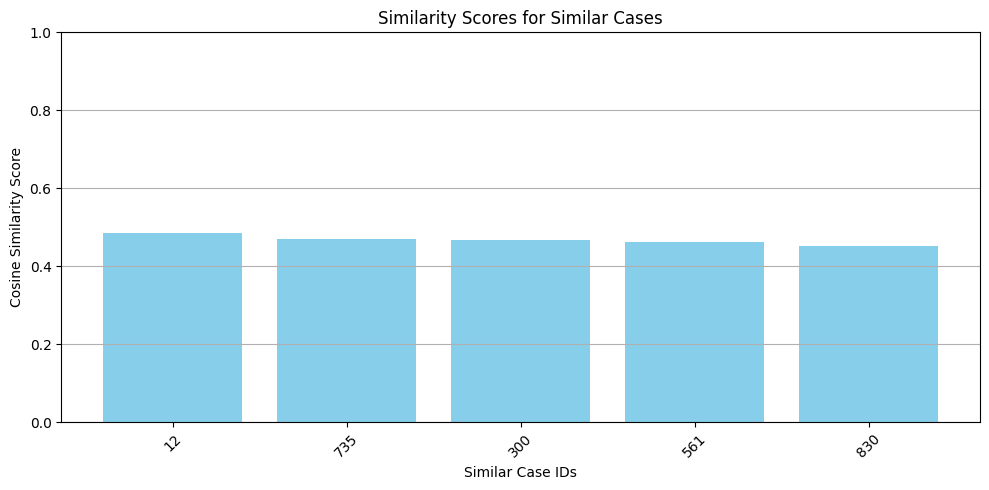

In [ ]:
# Plotting similarity scores
plt.figure(figsize=(10, 5))
plt.bar(range(len(similar_cases)), similar_cases['similarity_score'], color='skyblue')
plt.xticks(range(len(similar_cases)), similar_cases['case_id'].values, rotation=45)
plt.xlabel('Similar Case IDs')
plt.ylabel('Cosine Similarity Score')
plt.title('Similarity Scores for Similar Cases')
plt.ylim(0, 1)  # Similarity scores range from 0 to 1
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

## Use Case 2: Document Similarity and Clustering
Overview: This use case focuses on organizing legal documents based on their content through embedding and clustering techniques. By clustering similar documents, legal professionals can streamline document retrieval and enhance their document management processes.

### Implementation:

- **Embedding Legal Documents:** The text from legal documents is embedded using the same Sentence Transformer model. This allows the documents to be represented in a high-dimensional space, capturing their semantic relationships.

- **Cosine Similarity Calculation:** Similar to case summaries, cosine similarity is calculated for all legal documents, establishing a basis for clustering.

- **K-Means Clustering:** The K-Means algorithm is applied to group the document embeddings into clusters based on their similarities. Each cluster represents a distinct group of documents that share similar content.

- **Visualization:** A t-SNE plot visualizes the document clusters in a two-dimensional space, making it easy to observe the distribution of documents across different clusters.

- **Inspection of Clusters:** A function is provided to inspect documents within each cluster, enabling legal professionals to quickly identify key documents relevant to their cases or areas of interest.

### Business Value:

- **Enhanced Document Management:** Clustering facilitates easier organization and retrieval of legal documents, making it simpler for lawyers to find relevant materials.

- **Improved Research Efficiency:** By categorizing documents into clusters, legal teams can more quickly access documents that pertain to specific legal issues or cases.

- **Facilitated Knowledge Discovery:** The clustering approach may reveal connections between documents that were not immediately apparent, allowing for deeper insights and understanding of legal trends.

In [ ]:
# Load the legal documents dataset
df_legal_docs = pd.read_csv('legal_documents.csv')

# Display the first few rows
print(df_legal_docs.head())

   doc_id                                               text
0       1  In the case of Document 1, regarding Family La...
1       2  In the case of Document 2, regarding Intellect...
2       3  In the case of Document 3, regarding Intellect...
3       4  In the case of Document 4, regarding Contract ...
4       5  In the case of Document 5, regarding Tax Law, ...


In [ ]:
# Generate embeddings for all legal document texts
legal_doc_embeddings = model.encode(df_legal_docs['text'].tolist(), convert_to_tensor=True)

# Calculate cosine similarities between document embeddings
cosine_similarities = cosine_similarity(legal_doc_embeddings.cpu().numpy())

In [ ]:
# Function to find similar documents given a document ID
def find_similar_documents(doc_id, top_n=5):
    similarities = cosine_similarities[doc_id]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]  # Skip the document itself
    similar_docs = df_legal_docs.iloc[similar_indices]
    similarity_scores = similarities[similar_indices]

    return similar_docs, similarity_scores

In [ ]:
# Example: Find similar documents for doc_id 24 (first document)
doc_id_to_examine = 24
similar_docs, similarity_scores = find_similar_documents(doc_id_to_examine)

# Print details of the original document
print(f"Original Document ID: {df_legal_docs.iloc[doc_id_to_examine]['doc_id']}")
print(f"Text: {df_legal_docs.iloc[doc_id_to_examine]['text']}")

Original Document ID: 25
Text: In the case of Document 25, regarding Contract Law, The defendant was found not guilty. This case highlights that Negligence must be proven.


In [ ]:
# Print the top 5 most similar documents
print("\nMost similar documents:")

for i, (index, row) in enumerate(similar_docs.iterrows()):
    print(f"\nRank {i+1}:")
    print(f"Document ID: {row['doc_id']}")
    print(f"Text: {row['text'][:500]}...")  # Printing only first 500 chars
    print(f"Similarity Score: {similarity_scores[i]}")


Most similar documents:

Rank 1:
Document ID: 2464
Text: In the case of Document 2464, regarding Contract Law, The defendant was found not guilty. This case highlights that Negligence must be proven....
Similarity Score: 0.903069257736206

Rank 2:
Document ID: 2787
Text: In the case of Document 2787, regarding Contract Law, The defendant was found not guilty. This case highlights that Negligence must be proven....
Similarity Score: 0.8994434475898743

Rank 3:
Document ID: 2390
Text: In the case of Document 2390, regarding Contract Law, The defendant was found not guilty. This case highlights that Negligence must be proven....
Similarity Score: 0.892030656337738

Rank 4:
Document ID: 495
Text: In the case of Document 495, regarding Contract Law, The defendant was found not guilty. This case highlights that Negligence must be proven....
Similarity Score: 0.8876841068267822

Rank 5:
Document ID: 4698
Text: In the case of Document 4698, regarding Contract Law, The defendant was found not 

### K-Means Clustering

K-Means is an unsupervised machine learning algorithm used for partitioning data into distinct clusters based on their features. The algorithm aims to group data points into 𝐾 clusters by assigning each point to the cluster with the nearest mean (centroid).

Key Points:

- The algorithm begins with random centroids and iteratively updates them based on the mean of the assigned data points until convergence.
- K-Means is efficient and works well with spherical clusters, but it requires the number of clusters
- 𝐾 to be specified in advance, which can sometimes be challenging.
It can help organize large datasets, making it easier to analyze and interpret data by grouping similar items together.

In [ ]:
# Perform K-Means clustering on the document embeddings

num_clusters = 5  # Example: We want to create 5 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

df_legal_docs['cluster'] = kmeans.fit_predict(legal_doc_embeddings.cpu().numpy())

### t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in two or three dimensions. It works by converting the similarities between data points into joint probabilities and then aims to minimize the divergence between these probabilities in the high-dimensional space and the low-dimensional space.

Key Points:

- t-SNE preserves the local structure of the data, making similar points in high-dimensional space appear closer together in the lower-dimensional representation.
- It is especially useful for visualizing clusters and patterns in datasets, helping to identify relationships and structures that may not be apparent in the original high-dimensional data.

In [ ]:
# Visualize document clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42)
doc_embeddings_2d = tsne.fit_transform(legal_doc_embeddings.cpu().numpy())

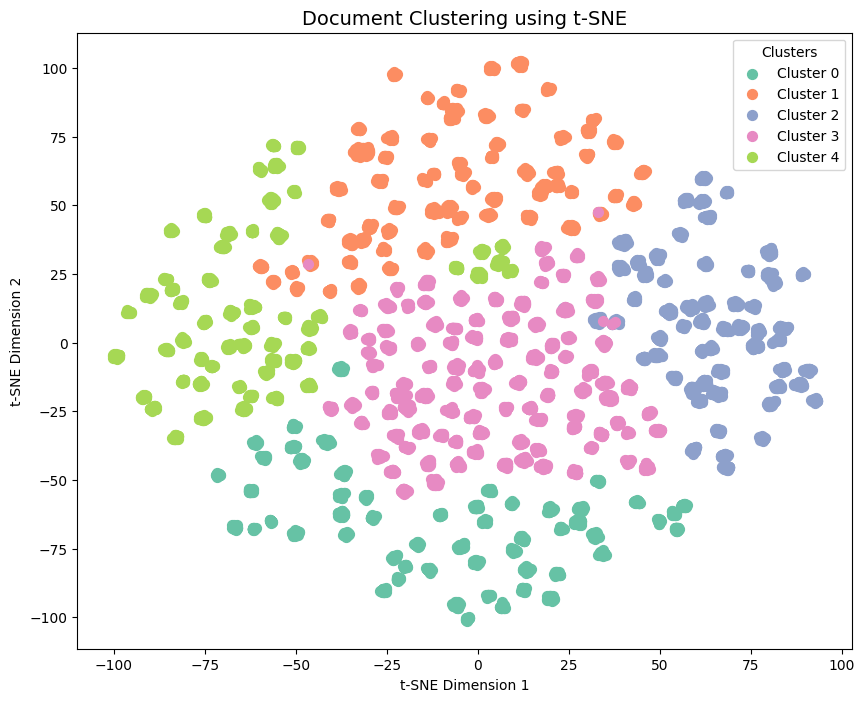

In [ ]:
# Define a color palette for the clusters
palette = sns.color_palette("Set2", num_clusters)

plt.figure(figsize=(10, 8))

# Plot each cluster with its corresponding color
for cluster in range(num_clusters):
    cluster_points = doc_embeddings_2d[df_legal_docs['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=palette[cluster], s=50)

# Add labels and title to the plot
plt.title("Document Clustering using t-SNE", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add a legend to map colors to clusters
plt.legend(title="Clusters")

# Show the plot
plt.show()

In [ ]:
# Function to inspect documents within each cluster
def inspect_clusters(df, num_clusters, num_examples=3):
    for cluster in range(num_clusters):
        print(f"\n--- Cluster {cluster} ---")
        cluster_docs = df[df['cluster'] == cluster][['doc_id', 'text']].head(num_examples)
        for idx, row in cluster_docs.iterrows():
            print(f"Document ID: {row['doc_id']}")
            print(f"Text: {row['text'][:500]}...")  # Print first 500 characters for brevity
            print("\n")

# Inspect 3 documents from each cluster
inspect_clusters(df_legal_docs, num_clusters, num_examples=3)


--- Cluster 0 ---
Document ID: 2
Text: In the case of Document 2, regarding Intellectual Property, The case was dismissed due to lack of evidence. This case highlights that Duty of care must be established....


Document ID: 3
Text: In the case of Document 3, regarding Intellectual Property, The ruling established a new precedent. This case highlights that Duty of care must be established....


Document ID: 6
Text: In the case of Document 6, regarding Corporate Law, The defendant was found not guilty. This case highlights that Duty of care must be established....



--- Cluster 1 ---
Document ID: 5
Text: In the case of Document 5, regarding Tax Law, The defendant was found not guilty. This case highlights that The 'reasonable person' standard in tort cases....


Document ID: 12
Text: In the case of Document 12, regarding Tax Law, The parties reached a settlement before trial. This case highlights that The 'reasonable person' standard in tort cases....


Document ID: 14
Text: In the ca